In [1]:
#!pip install --quiet pytorch-lightning
#!pip install --quiet tqdm
#!pip install shap
#!pip install lime
#!pip install boruta
#!pip install BorutaShap

In [2]:
import seaborn as sns  #Visualization
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import math
import matplotlib


import pandas as pd   #preprocessing
import numpy as np
from tqdm.notebook import tqdm
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.preprocessing import MinMaxScaler


import torch          #modelling
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict

from sklearn.model_selection import train_test_split

from sklearn.ensemble import GradientBoostingRegressor


import shap
from BorutaShap import BorutaShap

import os
from IPython.utils import io

import warnings
warnings.filterwarnings("ignore", ".*does not have many workers.*")
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 

In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid',palette='muted',font_scale=1.2)

HAPPY_COLORS_PALETTE = ['#01BEFE','#FFDD00','#FF7D00','#FF006D','#ADFF02','#8F00FF']

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize']=12,8

tqdm.pandas()

In [4]:
pl.seed_everything(8);

Global seed set to 8


In [5]:
folder_path = 'Predictions/Rossmann/5th_prediction/'

try:
    os.mkdir(f'{folder_path}')
except:
    pass

try:
    os.mkdir(f'{folder_path}/Stores')
except:
    pass
    

N_EPOCHS = 15
BATCH_SIZE = 7
SEQUENCE_LENGTH = 7
N_HIDDEN = 64
N_LAYERS = 4
PATIENCE = 2
LEARNING = 0.001

Boruta = True

In [6]:
def features_dataframe(df, corr):
    rows = []
    '''
    'Store', 'DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo',
       'SchoolHoliday', 'CompetitionDistance', 'CompetitionOpenSinceYear',
       'PromoInterval', 'Promo2', 'CompetitionOpenSinceMonth', 'year', 'month',
       'day', 'week', 'StoreType_a', 'StoreType_b', 'StoreType_c',
       'StoreType_d', 'Assortment_a', 'Assortment_b', 'Assortment_c',
       'StateHoliday_0', 'StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c',
        'have_competition'
    '''

    for _, row in df.iterrows():
        row_data = dict(
            Sales = row.Sales,
        )
        for column in corr:
            row_data[column] = row[column]
            
        rows.append(row_data)
    
    features_df = pd.DataFrame(rows)

    return features_df

def train_test_spliter(ratio,features_df ):
    train_size = int(len(features_df)-99)
    train_df, test_df = features_df[:train_size], features_df[train_size + 1:]

    return train_df, test_df, train_size

def data_scaler(train_df,test_df):
    scaler = MinMaxScaler(feature_range=(-1,1))
    scaler = scaler.fit(train_df)

    train_df = pd.DataFrame(
        scaler.transform(train_df),
        index = train_df.index,
        columns = train_df.columns
        )

    test_df = pd.DataFrame(
        scaler.transform(test_df),
        index = test_df.index,
        columns = test_df.columns
        )

    return train_df, test_df, scaler


def create_sequences (input_data:pd.DataFrame, target_column, sequence_length):
    sequences = []
    data_size = len(input_data)

    for i in (range(data_size - sequence_length)):

        sequence = input_data[i:i+sequence_length]

        label_position = i + sequence_length
        label = input_data.iloc[label_position][target_column]

        sequences.append((sequence,label))
    
    return sequences

def descale(descaler, values):
    values_2d=np.array(values)[:,np.newaxis]
    
    return descaler.inverse_transform(values_2d).flatten()


def dict_to_dataframe(dict_list,seq_size):
    
    column_names = []
    data = []
    
    for d in dict_list:
        features = d['sequence'].numpy().flatten()
        label = d['label'].numpy()
        data.append(np.concatenate((features, label), axis=None))
        
    df = pd.DataFrame(data)
    
    for j in range(seq_size):
        if seq_size-j >= 10:
            day_column_names = str(seq_size-j) + 'day_back'+'_' + train_df.columns
            column_names.extend(day_column_names)
        else:
            day_column_names = '0' + str(seq_size-j) + 'day_back'+'_' + train_df.columns
            column_names.extend(day_column_names)
        
    column_names.append('target')
    df.columns = column_names
    
    return df



class Dataset(Dataset):

    def __init__(self,sequences):
        self.sequences = sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self,idx):
        sequence, label = self.sequences[idx]

        return dict(
            sequence = torch.Tensor(sequence.to_numpy()),
            label = torch.tensor(label).float()
        )

class SalesDataModule(pl.LightningDataModule):

    def __init__(self, train_seqeunces,test_sequences, batch_size=8):
        super().__init__()
        self.train_sequences = train_sequences
        self.test_sequences = test_sequences
        self.batch_size = batch_size

    def setup(self,stage=None):
        self.train_dataset = Dataset(self.train_sequences)
        self.test_dataset = Dataset(self.test_sequences)

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size = self.batch_size,
            shuffle = False,
            num_workers = 0
        )

    def val_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size = 1,
            shuffle = False,
            num_workers = 0
        )


class SalesPredictionModel(nn.Module):
    def __init__(self, n_features, n_hidden = N_HIDDEN, n_layers = N_LAYERS):
        super().__init__()
        self.n_hidden = n_hidden

        self.lstm = nn.LSTM(
            input_size = n_features,
            hidden_size = n_hidden,
            batch_first = True,
            num_layers = n_layers,
            dropout = 0.2
        )
        self.regressor = nn.Linear(n_hidden,1)

    def forward(self,x):
        self.lstm.flatten_parameters()

        _, (hidden, _) = self.lstm(x)
        out = hidden[-1]
        
        return self.regressor(out)
    

class SalesPredictor(pl.LightningModule):

    def __init__(self, n_features: int):
        super().__init__()
        self.model=SalesPredictionModel(n_features)
        self.criterion = nn.MSELoss()

    def forward(self, x, labels= None):
        output = self.model(x)
        loss = 0
        if labels is not None:
            loss = self.criterion(output, labels.unsqueeze(dim=1))
        return loss, output
    
    def training_step(self, batch, batch_index):
        sequences = batch['sequence']
        labels = batch['label']

        loss, outputs = self(sequences, labels)
        self.log('train_loss', loss, prog_bar = True, logger=False)
        return loss

    def validation_step(self, batch, batch_index):
        sequences = batch['sequence']
        labels = batch['label']

        loss, outputs = self(sequences, labels)
        self.log('val_loss', loss, prog_bar = True, logger=False)
        return loss

    def test_step(self, batch, batch_index):
        sequences = batch['sequence']
        labels = batch['label']

        loss, outputs = self(sequences, labels)
        self.log('test_loss', loss, prog_bar = True, logger=False)
        return loss

    def configure_optimizers(self):
        return optim.AdamW(self.parameters(), lr = LEARNING)
        

In [7]:
df_og = pd.read_csv('Rossmann_treated.csv')


estimator = GradientBoostingRegressor()
selector = BorutaShap(estimator,importance_measure = 'shap', classification = False)


In [11]:
if Boruta == True:
    SEQUENCE_LENGTH = 30
    for store in tqdm(df_og['Store'].unique()[:1]):
        sales_dependencies = {}
        dic_features = {}
        
        df = df_og[df_og['Store'] == store].reset_index(drop = True)
        df.drop(columns  = 'Date', inplace = True)
        
        features  = (df.select_dtypes(include='float').dropna(axis=1, how='all')).columns.tolist()

        features_df = features_dataframe(df,list(df.columns))

        train_df, test_df, train_size =  train_test_spliter(99,features_df)
        train_df, test_df, scaler = data_scaler(train_df,test_df)
        train_sequences = create_sequences (train_df,'Sales',SEQUENCE_LENGTH)
        test_sequences = create_sequences (test_df,'Sales',SEQUENCE_LENGTH)
        data_module = SalesDataModule(train_sequences, test_sequences, batch_size = BATCH_SIZE)
        data_module.setup()

        train_dataset = Dataset(train_sequences)
        test_dataset = Dataset(test_sequences)
        
        data = dict_to_dataframe(train_dataset, SEQUENCE_LENGTH)

        with io.capture_output() as captured:
            selector.fit(data.iloc[:,:-1], data.iloc[:,-1], n_trials=100,
                        sample=False, train_or_test='train');

        important = list(selector.accepted)
        important = [i[11:] for i in important]
        important = list(set(important)) 

        unimportant = list(selector.rejected)
        unimportant = [i[11:] for i in unimportant]
        unimportant = list(set(unimportant))
        
        tentative = list(selector.tentative)
        tentative = [i[11:] for i in tentative]
        tentative = list(set(tentative))

        
        for i in important:
            if i in unimportant:
                unimportant.remove(i)
        for i in important:
            if i in tentative:
                tentative.remove(i)
        for i in unimportant:
            if i in tentative:
                tentative.remove(i)

        sales_dependencies = {'important' : important, 'unimportant': unimportant, 'tentative' : tentative}
        dic_features[f'store{store}'] = sales_dependencies 
        
        important_df = pd.DataFrame(important, columns=['important'])
        unimportant_df = pd.DataFrame(unimportant, columns=['unimportant'])
        tentative_df = pd.DataFrame(tentative, columns=['tentative'])

        try:
            os.mkdir(f'{folder_path}/Stores/store{int(store)}')
        except:
            pass
        
        # Concatenate data frames horizontally
        feature_by_importance_df = pd.concat([important_df, unimportant_df, tentative_df], axis=1)
        feature_by_importance_df.to_csv(f"{folder_path}/Stores/store{int(store)}/store{int(store)}_features.csv",
                                         index = False)
        
        print(sales_dependencies)

  0%|          | 0/1 [00:00<?, ?it/s]

{'important': ['Sales', 'Open', 'Promo', 'day', 'DayOfWeek', 'SchoolHoliday', 'Customers', 'week'], 'unimportant': ['year', 'Promo_2_active', 'StoreType_d', 'Promo2', 'have_competition', 'Assortment_a', 'StateHoliday_0', 'Store', 'CompetitionOpenSinceMonth', 'StoreType_b', 'month', 'StateHoliday_b', 'StateHoliday_a', 'StoreType_a', 'Assortment_b', 'StateHoliday_c', 'CompetitionOpenSinceYear', 'StoreType_c', 'Assortment_c', 'CompetitionDistance'], 'tentative': []}


In [9]:
error_ds = []

must_use= ['year', 'month','day','week','DayOfWeek']

SEQUENCE_LENGTH = 7

for store in tqdm(df_og['Store'].unique()[:1]):
    
    df = df_og[df_og['Store'] == store].reset_index(drop = True)
    
    sales_dependencies = {}

    dic = {}
    features = pd.read_csv(f"{folder_path}/Stores/store{int(store)}/store{int(store)}_features.csv") 
    important = list(features['important'].fillna(0))
    important = [elem for elem in important if elem != 0]

    features_df = features_dataframe(df,important)

    train_df, test_df, train_size =  train_test_spliter(99,features_df)
    train_df, test_df, scaler = data_scaler(train_df,test_df)
    train_sequences = create_sequences (train_df,'Sales',SEQUENCE_LENGTH)
    test_sequences = create_sequences (test_df,'Sales',SEQUENCE_LENGTH)
    data_module = SalesDataModule(train_sequences, test_sequences, batch_size = BATCH_SIZE)
    data_module.setup()

    train_dataset = Dataset(train_sequences)
    test_dataset = Dataset(test_sequences)

    model = SalesPredictor(n_features = train_df.shape[1])

    try:
        os.remove(f"{folder_path}Checkpoints/Rosmannn_prediction_store{int(store)}.ckpt")
    except:
        pass

    checkpoint_callback = ModelCheckpoint(
        dirpath = f'{folder_path}Checkpoints',
        filename = f'Rosmannn_prediction_store{int(store)}',
        save_top_k = 1,
        verbose = False ,
        monitor = 'val_loss',
        mode = 'min'
    )

    logger = TensorBoardLogger('lightning_logs', name = 'btc-price')
    early_stopping_callback = EarlyStopping(monitor= 'val_loss', patience = PATIENCE)

    trainer = pl.Trainer(
        logger = logger,
        callbacks=[early_stopping_callback, checkpoint_callback],
        max_epochs = N_EPOCHS,
        gpus = 0,
    )
    trainer.fit(model, data_module)

    trained_model = SalesPredictor.load_from_checkpoint(
    f'{folder_path}Checkpoints/Rosmannn_prediction_store{int(store)}.ckpt',
    n_features = train_df.shape[1]
    )
    test_dataset = Dataset(test_sequences)
    predictions = []
    labels = []

    for item in test_dataset:
        sequence = item['sequence']
        label = item['label']
        _,output = trained_model(sequence.unsqueeze(dim=0))
        predictions.append(output.item())
        labels.append(label.item())


    descaler = MinMaxScaler()
    descaler.min_, descaler.scale_ = scaler.min_[0], scaler.scale_[0]

    predictions_descaled = descale(descaler,predictions)
    labels_descaled = descale(descaler,labels)

    test_data = df[train_size+1:]
    test_sequences_data = test_data.iloc[SEQUENCE_LENGTH:]

    dates = matplotlib.dates.date2num(df['Date'].tolist())
    full_dates = matplotlib.dates.date2num(df.Date.tolist())

    predictions_descaled = np.where(predictions_descaled<0, 0, predictions_descaled)


    try:
        os.mkdir(f'{folder_path}/Stores/store{int(store)}')
    except:
        pass

    dic = {}

    dic[f'store{store}_truth'] = df['Sales']
    dic[f'store{store}_truth_dates'] = full_dates

    truth_df = pd.DataFrame.from_dict(dic)
    truth_df.to_csv(f"{folder_path}/Stores/store{int(store)}/truth_store{int(store)}.csv",index = False)

    dic= {}

    dic[f'store{store}_pred'] = predictions_descaled
    dic[f'store{store}_pred_dates'] = dates[-len(predictions_descaled):]

    prediction_df = pd.DataFrame.from_dict(dic)
    prediction_df.to_csv(f"{folder_path}/Stores/store{int(store)}/prediction_store{int(store)}.csv",index = False)

    features_df = pd.DataFrame.from_dict(sales_dependencies) 
    features_df.to_csv(f"{folder_path}/Stores/store{int(store)}/features_store{int(store)}.csv",index = False)


  0%|          | 0/1 [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type                 | Params
---------------------------------------------------
0 | model     | SalesPredictionModel | 119 K 
1 | criterion | MSELoss              | 0     
---------------------------------------------------
119 K     Trainable params
0         Non-trainable params
119 K     Total params
0.476     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

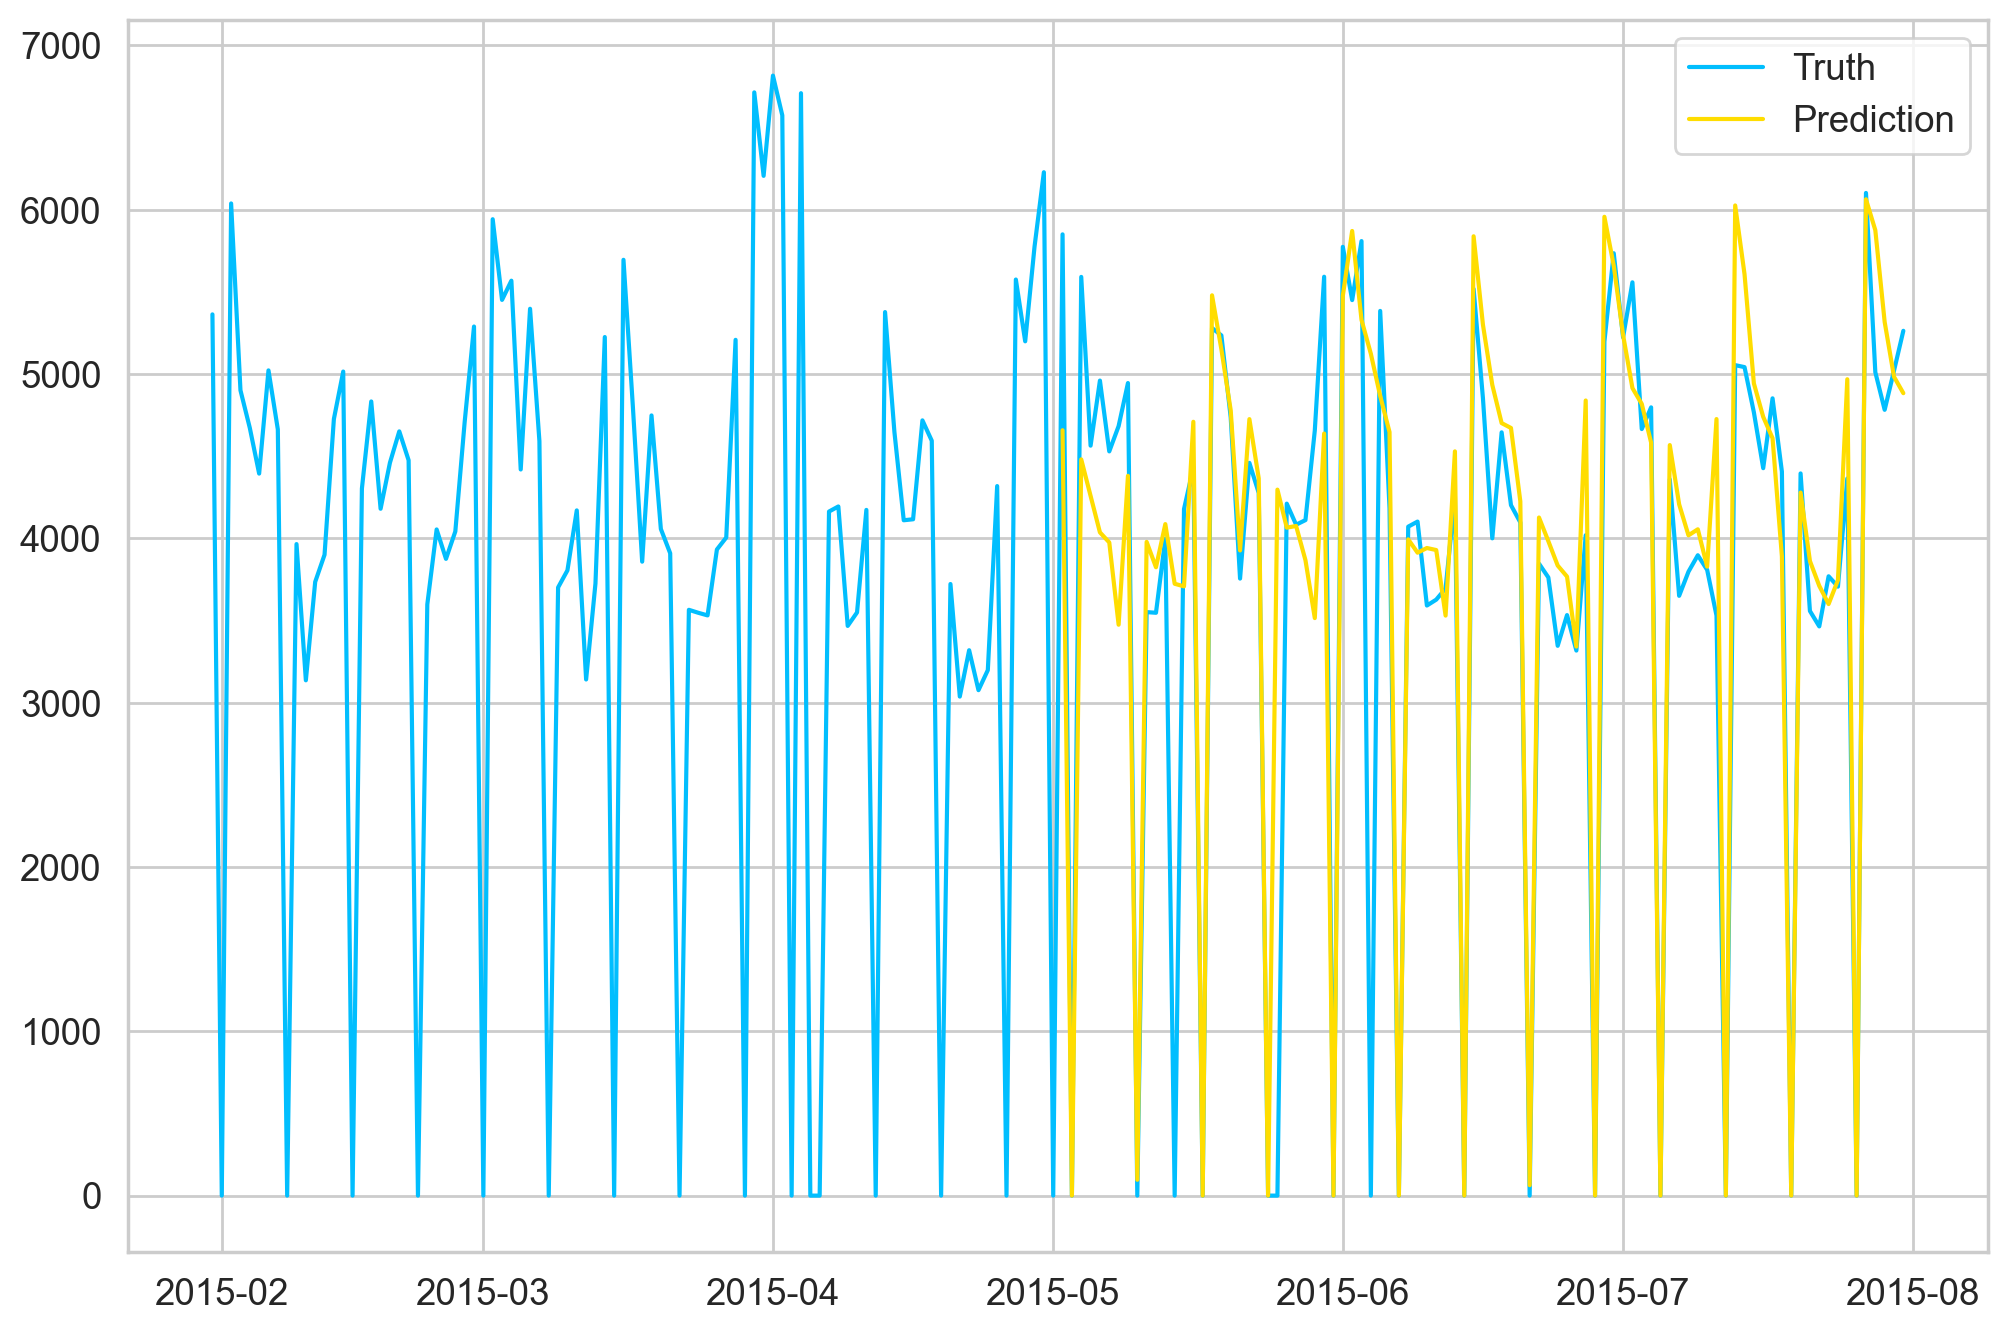

In [10]:
plt.plot_date(truth_df.iloc[-2*len(prediction_df):,1],truth_df.iloc[-2*len(prediction_df):,0],'-', label='Truth')
plt.plot_date(prediction_df.iloc[:,1],prediction_df.iloc[:,0],'-',label ='Prediction')
plt.legend();